# IHLT Lab 6

Lab developed by:
- Oriol Miró López-Feliu
- Niklas Long Schiefelbein


**Exercice description:**
1. Read all pairs of sentences of the SMTeuroparl files of test set within the evaluation framework of the project.
2. Apply WSD algorithms to the words in the sentences.
3. Compute their similarities by considering senses and Jaccard coefficient.
4. Compare the results with those in session 2 (document) and 3 (morphology) in which words and lemmas were considered.
5. Compare the results with gold standard by giving the pearson correlation between them.

## Imports

In [2]:
# basic
import pandas as pd
import nltk
import os
import json
from tqdm import tqdm # for ukb as it is quite slow

# preprocessing
from nltk.tokenize import word_tokenize
nltk.download('punkt')

from string import punctuation

nltk.download('stopwords')
stop_words = set(nltk.corpus.stopwords.words('english'))

nltk.download('averaged_perceptron_tagger')
from nltk import pos_tag

# distance
from nltk.metrics import jaccard_distance
from scipy.stats import pearsonr

# for lesk
import nltk
from nltk.wsd import lesk
nltk.download('wordnet')
nltk.download('omw-1.4')

# mount google drive (data loading & textserver)
from google.colab import drive
drive.mount('/content/drive')

# for textserver
import sys
sys.path.insert(0, '/content/drive/MyDrive/MAI_IHLT_LAB')
from textserver import TextServer

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


Mounted at /content/drive


## Useful functions

(Less bloated code)

In [3]:
# simple function for readibility
def get_wordnet_pos(nltk_pos_tag):
    if nltk_pos_tag.startswith('J'):
        return 'a'
    elif nltk_pos_tag.startswith('V'):
        return 'v'
    elif nltk_pos_tag.startswith('N'):
        return 'n'
    elif nltk_pos_tag.startswith('R'):
        return 'r'
    else:
        return None

# preprocessing
wnl = nltk.stem.WordNetLemmatizer()
def lemmatize(p):
  d = {'NN': 'n', 'NNS': 'n',
       'JJ': 'a', 'JJR': 'a', 'JJS': 'a',
       'VB': 'v', 'VBD': 'v', 'VBG': 'v', 'VBN': 'v', 'VBP': 'v', 'VBZ': 'v',
       'RB': 'r', 'RBR': 'r', 'RBS': 'r'}
  if p[1] in d:
    return wnl.lemmatize(p[0], pos=d[p[1]])
  return p[0]


def lemmatize_sentence(tokens):
    pos_tags = nltk.pos_tag(tokens)
    lemmatized_tokens = [lemmatize(pair) for pair in pos_tags]
    return lemmatized_tokens

# plotting

def compute_pearson_correlation(dt, column_name):
    return pearsonr(dt['gs'], dt[column_name])[0]

def plot_pearson_comparison(correlations, labels):

    # color palette (so we dont have to provide it, as variable nº of inputs)
    colors = sns.color_palette(n_colors=len(labels))

    # plot bar graph
    plt.figure(figsize=(8, 6))
    bars = plt.bar(labels, correlations, color=colors)

    plt.ylabel("Pearson's Correlation")
    plt.title("Comparison of Pearson's Correlation for Different Methods")
    plt.ylim(0, 1)  # Adjust the range based on your data

    # number above each bar (clarity)
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 3), ha='center', va='bottom')

    # show plot
    plt.show()

def display_examples(examples, title):
    print(f"\n{title}:\n")
    for idx, row in examples.iterrows():
        print(f"Sentence 1: {row['s0']}")
        print(f"Sentence 2: {row['s1']}")

        lab3_s0 = [word2 for word1, word2 in row['s0_preprocessed'] if word2 is not None]
        lab3_s1 = [word2 for word1, word2 in row['s1_preprocessed'] if word2 is not None]
        print(f"Lab3 Sentence 1: {lab3_s0}")
        print(f"Lab3 Sentence 2: {lab3_s1}")
        print(f"Current Sentence 1: {row['s0_synsets_and_preprocessed']}")
        print(f"Current Sentence 2: {row['s1_synsets_and_preprocessed']}")

        print(f"Gold Standard (gs): {row['gs']}")
        print(f"Jaccard (Lab 3): {row['jd_lab3']}")
        print(f"Jaccard (Current Lab): {row['jd_synsets_and_preprocessed']}")
        print(f"Difference (Lab 3): {row['diff_lab3']:.4f}")
        print(f"Difference (Current Lab): {row['diff_current_lab']:.4f}")
        print("-" * 50)

## Data Loading

In [4]:
# load base data
dt = pd.read_csv('/content/drive/MyDrive/MAI_IHLT_LAB/data/test-gold/STS.input.SMTeuroparl.txt',sep='\t',header=None)

# include the gs labels
dt['gs'] = pd.read_csv('/content/drive/MyDrive/MAI_IHLT_LAB/data/test-gold/STS.gs.SMTeuroparl.txt',sep='\t',header=None)

In [5]:
# preprocessing
dt.drop_duplicates(inplace=True) # as we found out last session that there are 142 duplicates!

# rename columns
dt.rename(columns={0:'s0', 1:'s1'}, inplace=True)

## Exercices

### Exercice 1
Apply WSD algorithms to the words in the sentences.

PD: this is really exercise 2 but we are not counting data loading

In [6]:
# preprocessing

# tokenize
dt['s0_tokens'] = dt.apply(lambda row: word_tokenize(row["s0"]), axis=1)
dt['s1_tokens'] = dt.apply(lambda row: word_tokenize(row["s1"]), axis=1)

#### Lesk

In [7]:
# NOTE: Function declared here as it is only used for this case

# function to disambiguate all tokens in a sentence using lesk (where applicable: open-class words)
def disambiguate_with_lesk(sentence_tokens):

    # 1. get all POS
    pos_tags = pos_tag(sentence_tokens)

    # 2. disambiguate
    disambiguated = [] # we return a list, (word, synset); synset == None if not applicable

    for token, nltk_pos in pos_tags:
        wn_pos = get_wordnet_pos(nltk_pos)
        if wn_pos:
            synset = lesk(sentence_tokens, token, wn_pos) # apply lesk
            disambiguated.append((token, synset.name() if synset else None))
        else:
            disambiguated.append((token, None))

    return disambiguated

In [8]:
# apply function
dt['s0_disambiguated_lesk'] = dt['s0_tokens'].apply(disambiguate_with_lesk)
dt['s1_disambiguated_lesk'] = dt['s1_tokens'].apply(disambiguate_with_lesk)

In [9]:
# check it was okay
print(dt['s0_disambiguated_lesk'].head())
print(dt['s0_disambiguated_lesk'].tail())

0    [(The, None), (leaders, leadership.n.02), (hav...
1    [(Amendment, amendment.n.02), (No, nobelium.n....
2    [(Let, let.v.01), (me, None), (remind, remind....
3    [(The, None), (vote, vote.n.05), (will, None),...
4    [(The, None), (fishermen, fisherman.n.01), (ar...
Name: s0_disambiguated_lesk, dtype: object
452    [(Then, then.r.02), (perhaps, possibly.r.01), ...
453    [(Let, let.v.01), (me, None), (remind, remind....
454    [(It, None), (is, be.v.01), (our, None), (job,...
455    [(The, None), (vote, vote.n.05), (will, None),...
457    [(Let, let.v.01), (me, None), (remind, remind....
Name: s0_disambiguated_lesk, dtype: object


#### UKB

NOTE: The code below contains our best effort; nevertheless, we abandoned ukb,because the server keeps banning us after a number of petitions,sometimes 50, sometimes 10 (!!?). Given we have to disambiguate 317*2 = 634 sentences and we must make a new account every time we are banned this is unfeasible.

In [11]:
# setup (this should be done with environment variables read from a file! but textserver kept banning os so...)
username = "uri_niki_3"
password = "hJ16XNA0."
ts = TextServer(username, password, "senses")

#### As per the professor, to save intermediate results:

In [12]:
# Check if the aux file exists, and load its content if it does

aux_file = 'disambiguation_results_ukb.json'

if os.path.exists(aux_file):
    with open(aux_file, 'r') as f:
        disambiguation_results = json.load(f)
else:
    disambiguation_results = {}

In [13]:
# function to disambiguate all tokens in a sentence using ukb, and save results
def disambiguate_with_ukb(sentence, key):
    # check if already processed
    if key in disambiguation_results:
        return disambiguation_results[key]

    # otherwise we process it
    try:
        # call text server
        result = ts.senses(sentence)

        # save result
        disambiguation_results[key] = result
        with open(aux_file, 'w') as f:
            json.dump(disambiguation_results, f)

        return result

    # it crashed (or banned us >:( )
    except Exception as e:
        print(f"Error processing sentence '{sentence}': {e}")
        return None

In [14]:
# try to apply ukb ("sx_idx" is a key to store the results)

# server keeps banning us at 50 petitions, sometimes at 10 (!!?)
# as per the professor we will ignore ukb despite our best efforts, as we have to disambiguate 317*2 = 634 sentences and we must make a new account every time.

dt['s0_disambiguated_ukb'] = [
    disambiguate_with_ukb(row['s0'], f"s0_{idx}") for idx, row in tqdm(dt.iterrows(), total=dt.shape[0])
]

# For sentences in column "s1" (use the index as part of the key)
dt['s1_disambiguated_ukb'] = [
    disambiguate_with_ukb(row['s1'], f"s1_{idx}") for idx, row in tqdm(dt.iterrows(), total=dt.shape[0])
]

 16%|█▌        | 51/317 [00:52<03:48,  1.16it/s]

Error processing sentence 'The leaders have now been given a new chance and let us hope they seize it.': 401 Client Error:  for url: http://frodo.lsi.upc.edu:8080/TextWS/textservlet/ws/processQuery/senses


 16%|█▋        | 52/317 [00:52<03:19,  1.33it/s]

Error processing sentence 'As I already explained during second reading, there is a crisis underlying this directive amendment.': 401 Client Error:  for url: http://frodo.lsi.upc.edu:8080/TextWS/textservlet/ws/processQuery/senses


 17%|█▋        | 53/317 [00:53<03:02,  1.45it/s]

Error processing sentence 'Van Orden Report (A5-0241/2000)': 401 Client Error:  for url: http://frodo.lsi.upc.edu:8080/TextWS/textservlet/ws/processQuery/senses


 17%|█▋        | 54/317 [00:53<02:45,  1.58it/s]

Error processing sentence 'Then perhaps we could have avoided a catastrophe.': 401 Client Error:  for url: http://frodo.lsi.upc.edu:8080/TextWS/textservlet/ws/processQuery/senses


 17%|█▋        | 55/317 [00:54<02:34,  1.69it/s]

Error processing sentence 'It is our job to continue to support Latvia with the integration of the Russian population.': 401 Client Error:  for url: http://frodo.lsi.upc.edu:8080/TextWS/textservlet/ws/processQuery/senses


 18%|█▊        | 56/317 [00:54<02:27,  1.77it/s]

Error processing sentence 'Mr President, I rise in defence of the workers in the industry.': 401 Client Error:  for url: http://frodo.lsi.upc.edu:8080/TextWS/textservlet/ws/processQuery/senses


 18%|█▊        | 57/317 [00:55<02:23,  1.81it/s]

Error processing sentence 'It is our job to continue to support Latvia with the integration of the Russian population.': 401 Client Error:  for url: http://frodo.lsi.upc.edu:8080/TextWS/textservlet/ws/processQuery/senses


 18%|█▊        | 58/317 [00:55<02:20,  1.84it/s]

Error processing sentence 'I am one of those Members who attends sittings quite faithfully.': 401 Client Error:  for url: http://frodo.lsi.upc.edu:8080/TextWS/textservlet/ws/processQuery/senses


 19%|█▊        | 59/317 [00:56<02:16,  1.89it/s]

Error processing sentence 'Let me remind you that our allies include fervent supporters of this tax.': 401 Client Error:  for url: http://frodo.lsi.upc.edu:8080/TextWS/textservlet/ws/processQuery/senses


 19%|█▉        | 60/317 [00:56<02:12,  1.94it/s]

Error processing sentence 'Unanimous decisions, and hence an inherent incapacity to act, remain largely the norm in the Council.': 401 Client Error:  for url: http://frodo.lsi.upc.edu:8080/TextWS/textservlet/ws/processQuery/senses


 19%|█▉        | 61/317 [00:57<02:11,  1.95it/s]

Error processing sentence 'Van Orden Report (A5-0241/2000)': 401 Client Error:  for url: http://frodo.lsi.upc.edu:8080/TextWS/textservlet/ws/processQuery/senses


 20%|█▉        | 62/317 [00:57<02:09,  1.98it/s]

Error processing sentence 'It is our job to continue to support Latvia with the integration of the Russian population.': 401 Client Error:  for url: http://frodo.lsi.upc.edu:8080/TextWS/textservlet/ws/processQuery/senses


 20%|█▉        | 63/317 [00:58<02:06,  2.00it/s]

Error processing sentence 'Van Orden Report (A5-0241/2000)': 401 Client Error:  for url: http://frodo.lsi.upc.edu:8080/TextWS/textservlet/ws/processQuery/senses


 20%|██        | 64/317 [00:58<02:04,  2.03it/s]

Error processing sentence 'Mr President, the Cashman report can be summarised in four words: citizens' power over bureaucracy.': 401 Client Error:  for url: http://frodo.lsi.upc.edu:8080/TextWS/textservlet/ws/processQuery/senses


 21%|██        | 65/317 [00:59<02:04,  2.02it/s]

Error processing sentence 'Consumers will lose out, employees will lose out, Europe will lose competitive strength and growth.': 401 Client Error:  for url: http://frodo.lsi.upc.edu:8080/TextWS/textservlet/ws/processQuery/senses


 21%|██        | 66/317 [00:59<02:03,  2.04it/s]

Error processing sentence 'It is our job to continue to support Latvia with the integration of the Russian population.': 401 Client Error:  for url: http://frodo.lsi.upc.edu:8080/TextWS/textservlet/ws/processQuery/senses


 21%|██        | 67/317 [01:00<02:50,  1.46it/s]

Error processing sentence 'That provision could open the door wide to arbitrariness.': 401 Client Error:  for url: http://frodo.lsi.upc.edu:8080/TextWS/textservlet/ws/processQuery/senses


 21%|██▏       | 68/317 [01:01<02:36,  1.59it/s]

Error processing sentence 'The fishermen are inactive, tired and disappointed.': 401 Client Error:  for url: http://frodo.lsi.upc.edu:8080/TextWS/textservlet/ws/processQuery/senses


 22%|██▏       | 69/317 [01:01<02:26,  1.69it/s]

Error processing sentence 'The European Union has got to do something and do it quickly.': 401 Client Error:  for url: http://frodo.lsi.upc.edu:8080/TextWS/textservlet/ws/processQuery/senses


 22%|██▏       | 70/317 [01:02<02:17,  1.79it/s]

Error processing sentence 'It increases the power of the big countries at the expense of the small countries.': 401 Client Error:  for url: http://frodo.lsi.upc.edu:8080/TextWS/textservlet/ws/processQuery/senses


 22%|██▏       | 71/317 [01:02<02:11,  1.87it/s]

Error processing sentence 'The standards are scarcely comparable, let alone transferable.': 401 Client Error:  for url: http://frodo.lsi.upc.edu:8080/TextWS/textservlet/ws/processQuery/senses


 23%|██▎       | 72/317 [01:03<02:08,  1.91it/s]

Error processing sentence 'The standards are scarcely comparable, let alone transferable.': 401 Client Error:  for url: http://frodo.lsi.upc.edu:8080/TextWS/textservlet/ws/processQuery/senses


 23%|██▎       | 73/317 [01:03<02:04,  1.96it/s]

Error processing sentence 'Neither was there a qualified majority within this House to revert to Article 272.': 401 Client Error:  for url: http://frodo.lsi.upc.edu:8080/TextWS/textservlet/ws/processQuery/senses


 23%|██▎       | 74/317 [01:04<02:04,  1.95it/s]

Error processing sentence 'Amendment No 7 proposes certain changes in the references to paragraphs.': 401 Client Error:  for url: http://frodo.lsi.upc.edu:8080/TextWS/textservlet/ws/processQuery/senses


 24%|██▎       | 75/317 [01:04<02:02,  1.97it/s]

Error processing sentence 'Van Orden Report (A5-0241/2000)': 401 Client Error:  for url: http://frodo.lsi.upc.edu:8080/TextWS/textservlet/ws/processQuery/senses


 24%|██▍       | 76/317 [01:05<02:02,  1.97it/s]

Error processing sentence 'Mr President, I rise in defence of the workers in the industry.': 401 Client Error:  for url: http://frodo.lsi.upc.edu:8080/TextWS/textservlet/ws/processQuery/senses


 24%|██▍       | 77/317 [01:05<01:59,  2.01it/s]

Error processing sentence 'That provision could open the door wide to arbitrariness.': 401 Client Error:  for url: http://frodo.lsi.upc.edu:8080/TextWS/textservlet/ws/processQuery/senses


 25%|██▍       | 78/317 [01:06<02:00,  1.99it/s]

Error processing sentence 'Mr President, the Cashman report can be summarised in four words: citizens' power over bureaucracy.': 401 Client Error:  for url: http://frodo.lsi.upc.edu:8080/TextWS/textservlet/ws/processQuery/senses


 25%|██▍       | 79/317 [01:06<01:59,  2.00it/s]

Error processing sentence 'Consumers will lose out, employees will lose out, Europe will lose competitive strength and growth.': 401 Client Error:  for url: http://frodo.lsi.upc.edu:8080/TextWS/textservlet/ws/processQuery/senses


 25%|██▌       | 80/317 [01:07<01:58,  2.00it/s]

Error processing sentence 'It increases the power of the big countries at the expense of the small countries.': 401 Client Error:  for url: http://frodo.lsi.upc.edu:8080/TextWS/textservlet/ws/processQuery/senses


 26%|██▌       | 81/317 [01:07<01:59,  1.98it/s]

Error processing sentence 'I am one of those Members who attends sittings quite faithfully.': 401 Client Error:  for url: http://frodo.lsi.upc.edu:8080/TextWS/textservlet/ws/processQuery/senses


 26%|██▌       | 82/317 [01:08<01:58,  1.99it/s]

Error processing sentence 'The leaders have now been given a new chance and let us hope they seize it.': 401 Client Error:  for url: http://frodo.lsi.upc.edu:8080/TextWS/textservlet/ws/processQuery/senses


 26%|██▌       | 83/317 [01:08<01:57,  1.99it/s]

Error processing sentence 'Selective aid, such as market support and a grass subsidy, are essential.': 401 Client Error:  for url: http://frodo.lsi.upc.edu:8080/TextWS/textservlet/ws/processQuery/senses


 26%|██▋       | 84/317 [01:09<01:56,  2.00it/s]

Error processing sentence 'I am one of those Members who attends sittings quite faithfully.': 401 Client Error:  for url: http://frodo.lsi.upc.edu:8080/TextWS/textservlet/ws/processQuery/senses


 27%|██▋       | 85/317 [01:09<01:56,  2.00it/s]

Error processing sentence 'There must be a balance as a whole.': 401 Client Error:  for url: http://frodo.lsi.upc.edu:8080/TextWS/textservlet/ws/processQuery/senses


 27%|██▋       | 86/317 [01:10<01:54,  2.02it/s]

Error processing sentence 'Mr President, I rise in defence of the workers in the industry.': 401 Client Error:  for url: http://frodo.lsi.upc.edu:8080/TextWS/textservlet/ws/processQuery/senses


 27%|██▋       | 87/317 [01:10<01:56,  1.97it/s]

Error processing sentence 'Then perhaps we could have avoided a catastrophe.': 401 Client Error:  for url: http://frodo.lsi.upc.edu:8080/TextWS/textservlet/ws/processQuery/senses


 28%|██▊       | 88/317 [01:11<01:58,  1.92it/s]

Error processing sentence 'The European Union has got to do something and do it quickly.': 401 Client Error:  for url: http://frodo.lsi.upc.edu:8080/TextWS/textservlet/ws/processQuery/senses


 28%|██▊       | 89/317 [01:11<01:59,  1.91it/s]

Error processing sentence 'Selective aid, such as market support and a grass subsidy, are essential.': 401 Client Error:  for url: http://frodo.lsi.upc.edu:8080/TextWS/textservlet/ws/processQuery/senses


 28%|██▊       | 90/317 [01:12<01:57,  1.93it/s]

Error processing sentence 'Mr President, I rise in defence of the workers in the industry.': 401 Client Error:  for url: http://frodo.lsi.upc.edu:8080/TextWS/textservlet/ws/processQuery/senses


 29%|██▊       | 91/317 [01:13<01:57,  1.92it/s]

Error processing sentence 'The vote will take place today at 5.30 p.m.': 401 Client Error:  for url: http://frodo.lsi.upc.edu:8080/TextWS/textservlet/ws/processQuery/senses


 29%|██▉       | 92/317 [01:13<01:56,  1.94it/s]

Error processing sentence 'That provision could open the door wide to arbitrariness.': 401 Client Error:  for url: http://frodo.lsi.upc.edu:8080/TextWS/textservlet/ws/processQuery/senses


 29%|██▉       | 93/317 [01:14<01:54,  1.95it/s]

Error processing sentence 'As I already explained during second reading, there is a crisis underlying this directive amendment.': 401 Client Error:  for url: http://frodo.lsi.upc.edu:8080/TextWS/textservlet/ws/processQuery/senses


 30%|██▉       | 94/317 [01:14<01:52,  1.98it/s]

Error processing sentence 'The European Union has got to do something and do it quickly.': 401 Client Error:  for url: http://frodo.lsi.upc.edu:8080/TextWS/textservlet/ws/processQuery/senses


 30%|██▉       | 95/317 [01:15<01:51,  1.99it/s]

Error processing sentence 'Unanimous decisions, and hence an inherent incapacity to act, remain largely the norm in the Council.': 401 Client Error:  for url: http://frodo.lsi.upc.edu:8080/TextWS/textservlet/ws/processQuery/senses


 30%|███       | 96/317 [01:15<01:51,  1.99it/s]

Error processing sentence 'As I already explained during second reading, there is a crisis underlying this directive amendment.': 401 Client Error:  for url: http://frodo.lsi.upc.edu:8080/TextWS/textservlet/ws/processQuery/senses


 31%|███       | 97/317 [01:17<03:31,  1.04it/s]

Error processing sentence 'Mr President, I rise in defence of the workers in the industry.': 401 Client Error:  for url: http://frodo.lsi.upc.edu:8080/TextWS/textservlet/ws/processQuery/senses


KeyboardInterrupt: 

### Exercice 2

Compute their similarities by considering senses and Jaccard coefficient.

We will experiment with using and not using surrounding words.

In [15]:
# for when we keep surrounding words, we must preprocess them:
# - lowercase
# - lemmatise
# - remove punctuation
# - remove stopwords

# because we want to combine it with the synsets later on, we keep pair for each word (original, preprocessed), where preprocessed = None if it did not survive.

dt['s0_preprocessed'] = dt['s0_tokens'].apply(
    lambda tokens: [
        (word, word.lower() if word.lower() not in stop_words and word not in punctuation else None)
        for word in lemmatize_sentence(tokens)
    ]
)

dt['s1_preprocessed'] = dt['s1_tokens'].apply(
    lambda tokens: [
        (word, word.lower() if word.lower() not in stop_words and word not in punctuation else None)
        for word in lemmatize_sentence(tokens)
    ]
)


In [16]:
# now this code is a bit convoluted; we want to compute:
#   1. jaccard distance with only synset
#   2. with synset and surrounding preprocessed words.
# we will take advantage of having a pair (original, preprocessed) and (original, synset) for every word!

# case 1
def get_only_synsets(disambiguated_lesk):
    synsets = set()
    for word, synset in disambiguated_lesk:
        if synset:  # use synset only if it exists
            synsets.add(synset)
    return synsets

# case 2
def get_synsets_and_preprocessed(disambiguated_lesk, preprocessed):
    combined = set()
    for (word, synset), (orig, preproc) in zip(disambiguated_lesk, preprocessed):
        if synset:  # if synset use it
            combined.add(synset)
        elif preproc:  # otherwise if preprocessed word, use it
            combined.add(preproc)
    return combined

In [17]:
# computations!

# case 1
dt['jd_only_synsets'] = dt.apply(
    lambda row: (1 - jaccard_distance(
        get_only_synsets(row['s0_disambiguated_lesk']),
        get_only_synsets(row['s1_disambiguated_lesk'])
    )) * 5,
    axis=1
)

# case 2
dt['jd_synsets_and_preprocessed'] = dt.apply(
    lambda row: (1 - jaccard_distance(
        get_synsets_and_preprocessed(row['s0_disambiguated_lesk'], row['s0_preprocessed']),
        get_synsets_and_preprocessed(row['s1_disambiguated_lesk'], row['s1_preprocessed'])
    )) * 5,
    axis=1
)

# we save this for later analysis...:
dt['s0_synsets_and_preprocessed'] = dt.apply(
    lambda row: get_synsets_and_preprocessed(row['s0_disambiguated_lesk'], row['s0_preprocessed']),
    axis=1
)

dt['s1_synsets_and_preprocessed'] = dt.apply(
    lambda row: get_synsets_and_preprocessed(row['s1_disambiguated_lesk'], row['s1_preprocessed']),
    axis=1
)

#### Which is better? Let's compare

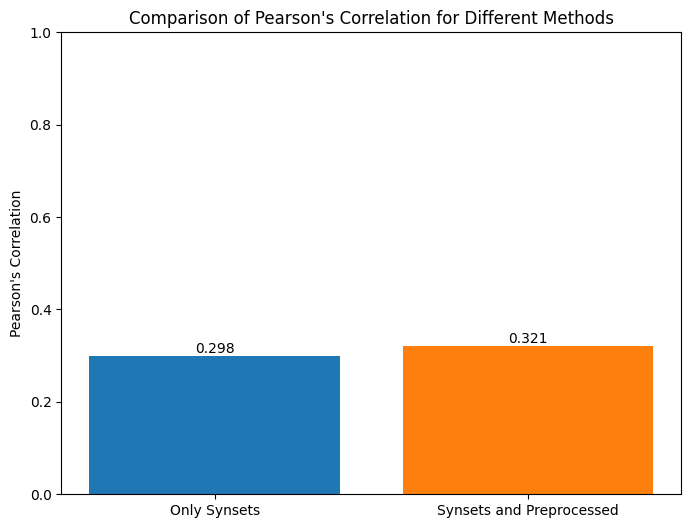

In [18]:
pearson_only_synsets              = compute_pearson_correlation(dt, 'jd_only_synsets')
pearson_synsets_and_preprocessed  = compute_pearson_correlation(dt, 'jd_synsets_and_preprocessed')

plot_pearson_comparison(
    [pearson_only_synsets, pearson_synsets_and_preprocessed],
    ['Only Synsets', 'Synsets and Preprocessed']
)

### Exercices 3 and 4

3. Compare the results with those in session 2 (document) and 3 (morphology) in which words and lemmas were considered.
4. Compare the results with gold standard by giving the pearson correlation between them.

We will first compare all pearson correlations

In [20]:
# lab 2 results:
dt['jd_lab2'] = dt.apply(
    lambda row: (1 - jaccard_distance(
        set([word.lower() for word in word_tokenize(row["s0"]) if word.lower() not in stop_words and word not in punctuation]),
        set([word.lower() for word in word_tokenize(row["s1"]) if word.lower() not in stop_words and word not in punctuation])
    )) * 5, axis=1
)

pearson_lab2 = compute_pearson_correlation(dt, 'jd_lab2')

# as our preprocessing was already lab 3's!
dt['jd_lab3'] = dt.apply(
    lambda row: (1 - jaccard_distance(
        set([word[1] for word in row['s0_preprocessed'] if word[1] is not None]),  # use only the second element if not None
        set([word[1] for word in row['s1_preprocessed'] if word[1] is not None])
    )) * 5, axis=1
)


pearson_lab3 = compute_pearson_correlation(dt, 'jd_lab3')

print(f"Pearson's correlation with lab 2: {pearson_lab2:.3f}")
print(f"Pearson's correlation with lab 3: {pearson_lab3:.3f}")

Pearson's correlation with lab 2: 0.379
Pearson's correlation with lab 3: 0.401


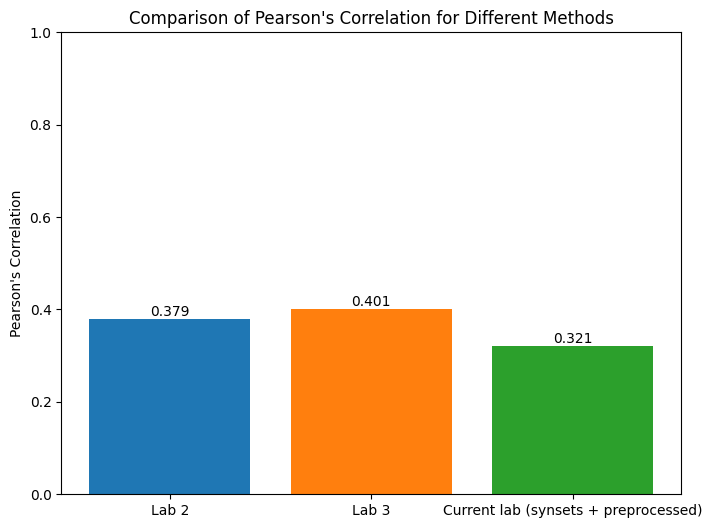

In [21]:
plot_pearson_comparison(
    [pearson_lab2, pearson_lab3, pearson_synsets_and_preprocessed],
    ['Lab 2', 'Lab 3', 'Current lab (synsets + preprocessed)']
)

**Analysis:** We seemed to have a decay in performance! Apparently using only synsets and the preprocessing is worse than just using the preprocessing (lab3). Let's study individual cases to understand why this might happen. We will compare the current lab vs lab 3, as so far it is what offered the best results.

In [22]:
# we have done this analysis in a previous lab

# cases where current lab worked better
# to find more illustrative examples, we find cases where the difference in performance was greater
dt['diff_lab3']         = (dt['jd_lab3'] - dt['gs']).abs()
dt['diff_current_lab']  = (dt['jd_synsets_and_preprocessed'] - dt['gs']).abs()
filtered_cases_better   = dt[dt['diff_current_lab'] < dt['diff_lab3']]
filtered_cases_equal    = dt[dt['diff_current_lab'] == dt['diff_lab3']]
filtered_cases_worse    = dt[dt['diff_current_lab'] > dt['diff_lab3']]

print(f"Current lab performed:")
print(f"  - Better in {len(filtered_cases_better)} cases ({(len(filtered_cases_better)/len(dt))*100:.2f}% of total)")
print(f"  - Equally in {len(filtered_cases_equal)} cases ({(len(filtered_cases_equal)/len(dt)*100):.2f}% of total)")
print(f"  - Worse in {len(filtered_cases_worse)} cases ({(len(filtered_cases_worse)/len(dt))*100:.2f}% of total)")

Current lab performed:
  - Better in 46 cases (14.51% of total)
  - Equally in 59 cases (18.61% of total)
  - Worse in 212 cases (66.88% of total)


Let us now visualise some cases where it performed better, and some cases where it performed worse:

In [23]:
# first, order them...
dt['diff_better'] = dt['diff_lab3'] - dt['diff_current_lab']
dt['diff_worse']  = dt['diff_current_lab'] - dt['diff_lab3']

filtered_cases_better = dt.sort_values(by='diff_better', ascending=False)
filtered_cases_worse  = dt.sort_values(by='diff_worse', ascending=False)

In [24]:
examples_better = filtered_cases_better.head(5)
display_examples(examples_better, "Examples where the current lab performed better")


Examples where the current lab performed better:

Sentence 1: The fishermen are inactive, tired and disappointed.
Sentence 2: The fishers are inactive, tired and disappointed.
Lab3 Sentence 1: ['fisherman', 'inactive', 'tired', 'disappointed']
Lab3 Sentence 2: ['fisher', 'inactive', 'tired', 'disappointed']
Current Sentence 1: {'fisherman.n.01', 'exist.v.01', 'disappointed', 'tired.a.01', 'dormant.a.02'}
Current Sentence 2: {'fisherman.n.01', 'exist.v.01', 'disappointed', 'tired.a.01', 'dormant.a.02'}
Gold Standard (gs): 5.0
Jaccard (Lab 3): 3.0
Jaccard (Current Lab): 5.0
Difference (Lab 3): 2.0000
Difference (Current Lab): 0.0000
--------------------------------------------------
Sentence 1: Then perhaps we could have avoided a catastrophe.
Sentence 2: We maybe then could have avoided a catastrophe.
Lab3 Sentence 1: ['perhaps', 'could', 'avoid', 'catastrophe']
Lab3 Sentence 2: ['maybe', 'could', 'avoid', 'catastrophe']
Current Sentence 1: {'then.r.02', 'possibly.r.01', 'could', 'cata

In [ ]:
examples_worse = filtered_cases_worse.head(5)
display_examples(examples_worse, "Examples where the current lab performed worse")


Examples where the current lab performed worse:

Sentence 1: There must be a balance as a whole.
Sentence 2: The whole must be balanced.
Lab3 Sentence 1: ['must', 'balance', 'whole']
Lab3 Sentence 2: ['whole', 'must', 'balance']
Current Sentence 1: {'embody.v.02', 'proportion.n.05', 'must', 'whole.n.02'}
Current Sentence 2: {'exist.v.01', 'whole.a.02', 'balance.v.04', 'must'}
Gold Standard (gs): 4.25
Jaccard (Lab 3): 5.0
Jaccard (Current Lab): 0.7142857142857145
Difference (Lab 3): 0.7500
Difference (Current Lab): 3.5357
--------------------------------------------------
Sentence 1: There must be a balance as a whole.
Sentence 2: The whole must be in balance.
Lab3 Sentence 1: ['must', 'balance', 'whole']
Lab3 Sentence 2: ['whole', 'must', 'balance']
Current Sentence 1: {'embody.v.02', 'proportion.n.05', 'must', 'whole.n.02'}
Current Sentence 2: {'proportion.n.05', 'exist.v.01', 'whole.a.02', 'must'}
Gold Standard (gs): 4.667
Jaccard (Lab 3): 5.0
Jaccard (Current Lab): 1.66666666666666

**Final Analysis and Conclusion:**


Our current approach underperformed compared to Lab 3, as indicated by a lower Pearson correlation with the gold standard (0.321 vs. 0.401) and worse performance in 66.88% of cases. This underperformance can be attributed to the increased lexical diversity and potential mismatches introduced by synset substitution, which negatively affected the Jaccard similarity.

When we substitute words with synsets, we aimed to capture the "meaning" of words; however, this often resulted in larger and more heterogeneous sets of tokens, reducing the likelihood of overlap between the synset sets of similar sentences. For instance, in the sentence pair "There must be a balance as a whole" and "The whole must be balanced," Lab 3 maintained a high similarity score due to direct word matches like "must," "balance," and "whole." In contrast, the current approach introduced synsets such as 'embody.v.02' and 'proportion.n.05' for "balance" and "whole," which did not align directly with the synsets in the second sentence. Given Jaccard similarity only accounts for perfect matches between words, we obtained a lower score.

Another example is the sentences "Mr President, the Cashman report can be summarised in four words: citizens' power over bureaucracy" and its counterpart. The synset substitution introduced different senses for words like "report," "president," and "words," resulting in less overlap despite the sentences being semantically similar; on the other hand, in Lab 3 the lemmatized words remained consistent and resulted in a higher similarity score.

However, there were cases where our current approach outperformed Lab 3, when synsets captured semantic similarities not evident when direct word matching. For example, in the sentence pair "The fishermen are inactive, tired and disappointed." and "The fishers are inactive, tired and disappointed," Lab 3 treated "fisherman" and "fisher" as different words, resulting in a lower similarity score, while the current lab's approach identified the same synset 'fisherman.n.01'. Similarly, in the sentences "Then perhaps we could have avoided a catastrophe." and "We maybe then could have avoided a catastrophe," the words "perhaps" and "maybe" were mapped to related synsets like 'possibly.r.01,'. These examples show that, in some cases, synsets could be prefered (when synonymous or semantically related words are used), as lab 3's simple preprocessing will never capture that.





